# Timing Core Equity Factors

M2 203 Econometrics Project, Faune Blanchard

--- 

## Preliminary preparations

First and foremost, we start by importing the packages that we will need to conduct this work.

Then, we import the data file, and do some quick preprocessing: we differentiate the first column which corresponds to the index, from the other columns which correspond to the components.

We use Polars instead of Pandas because of the added speed and flexibility.

We also import locally from our pre-coded functions in models.py

In [110]:
import polars as pl 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.

In [124]:
raw_data = pl.read_excel(source=r".\DATA.xlsx").rename({'__UNNAMED__0' : 'date'})
index = raw_data.select('date', pl.col("^.*ESTX 50.*$").alias("index"))
stocks = raw_data.drop("^.*ESTX 50.*$")
del raw_data # we won't need this variable anymore

## **Part 1**  

We want to extract the first latent factor of the index,  by using principal component analysis. 

The goal is to find the most important unobservable random variable that could explain the index's returns.

We do not need to scale the data as we are dealing with returns which are all on the same scale.

In [126]:
stocks_list = stocks.drop('date').transpose().select(pl.concat_list(pl.all()).alias('stocks')).to_series().to_list()
pca = PCA(1)
pca.fit_transform(stocks_list)
pc1 = pl.Series(name = "PC1", values=pca.components_).explode()

print(f"The explained variance ratio is {pca.explained_variance_ratio_[0]*100} %")

The explained variance ratio is 14.16698041033284 %


We count the percentage of negative values (if it's lower than 50% then we don't need to adjust)

In [129]:
pl.DataFrame(pc1).filter(pl.col('PC1').le(0)).shape[0]/pl.DataFrame(pc1).shape[0]

0.475177304964539

We plot the first results

<Axes: xlabel='date'>

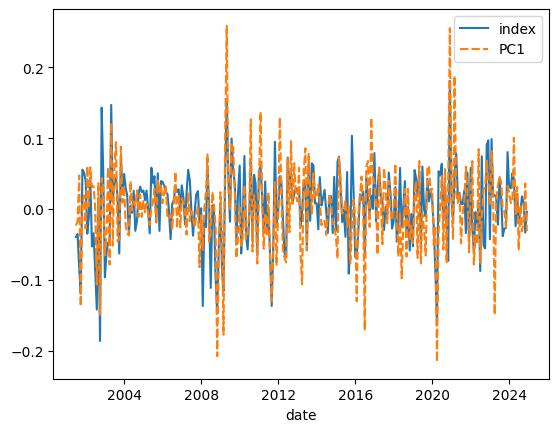

In [127]:
sns.lineplot(index.with_columns(pc1).to_pandas().set_index('date'))

We can then rescale the principal component to the same volatility as that of the benchmark.

We have

In [133]:
print(f"Principal component std : {pc1.std()} \nIndex std : {index.select('index').std().to_series().to_list()[0]}")

Principal component std : 0.0596517537500593 
Index std : 0.05220421089896673


In [134]:
pc1_rescaled = pl.DataFrame(pc1).select(pl.col('PC1').mul(index.select('index').std().to_series().to_list()[0]/pc1.std()))

<Axes: xlabel='date'>

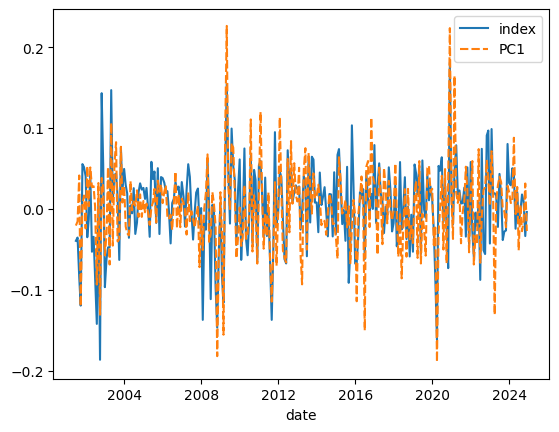

In [136]:
sns.lineplot(index.with_columns(pc1_rescaled).to_pandas().set_index('date'))

We then regress each stock returns on this principal component, using a linear regression